In [1]:
##########################################################################
##
## Train the Model on Oxford-IIIT Pet Dataset Through Supervised Learning
##
## Author:  Peizhi Yan
##   Date:  Mar. 7, 2021
##
##########################################################################

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.compat.v1 import keras
from tensorflow.compat.v1.keras import layers

import model.unet_xception as unet_xception

import pet_dataset_handler as pet
from pet_dataset_handler import PetDataGenerator

from cosine_annealing import CosineAnnealingScheduler

import loss


W0308 15:08:33.518649 16988 deprecation.py:323] From C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\compat\v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def plot_loss(history, save_path):
    # summarize history for loss
    plt.plot(history.history['loss'], color='indigo')
    plt.plot(history.history['val_loss'], color='deepskyblue')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.savefig(fname=save_path, dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format='pdf',
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)
    plt.show()
    
def save_history(history, save_path):
    js = json.dumps(str(history.history))
    f = open(save_path,"w")
    f.write(js)
    f.close()

In [3]:
""" Create the Xception network-based U-Net-like model """
model = unet_xception.get_model(img_size=(224,224), num_classes=2)
model.summary()

W0308 15:07:29.116693 20996 deprecation.py:506] From C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:1666: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Experiment 1

### Categorical Cross-Entropy (CCE) Loss for Semantic Segmentation:

$n$: number of pixels

$c$: classes

$\textrm{cce} = -\sum_i^c \sum_j^n y_i^j\log{\hat{y}_i^j}$



### Experiment 1a
#### w/o Data Augmentation

In [25]:
EXPERIMENT_NAME = 'cce_loss__no_aug'

if not os.path.exists('./saved_models/'+EXPERIMENT_NAME):
    os.makedirs('./saved_models/'+EXPERIMENT_NAME)

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

""" Create the Xception network-based U-Net-like model """
model = unet_xception.get_model(img_size=(224,224), num_classes=2)

""" Create training and validation data generators """
train_gen = PetDataGenerator(data_path='./data/224x224/train', batch_size=8, augmentation=False, shuffle=True)
val_gen = PetDataGenerator(data_path='./data/224x224/val', batch_size=32, augmentation=False, shuffle=False)

""" Optimizer """
opt = keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)

""" Cosine annealing learning rate scheduler """
cos_annealing = CosineAnnealingScheduler(T_max=10, eta_max=1e-3, eta_min=1e-5)

""" Automatically save the best model """
checkpoint = keras.callbacks.ModelCheckpoint('./saved_models/'+EXPERIMENT_NAME+'/{epoch:03d}-{loss:03f}-{val_loss:03f}.h5',
                                             verbose=0, monitor='val_loss',save_best_only=True, mode='auto')

""" Compile model """
model.compile(optimizer=opt, loss="categorical_crossentropy")

""" Train model """
callbacks = [checkpoint, cos_annealing]
history = model.fit(train_gen, validation_data=val_gen, epochs=50, verbose=1, callbacks=callbacks)

#""" Save model """
#model.save_weights('./saved_models/'+EXPERIMENT_NAME+'.h5')

""" Save history """
save_history(history, save_path='./logs/'+EXPERIMENT_NAME+'.json')

""" Plot history """  
plot_loss(history, save_path='./plots/'+EXPERIMENT_NAME+'.pdf')

Epoch 1/50
218/218 [==============================] - 58s 268ms/step - loss: 0.7300 - val_loss: 2.6481 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 56s 258ms/step - loss: 0.4217 - val_loss: 2.5195 - lr: 9.7577e-04
Epoch 3/50
218/218 [==============================] - 55s 250ms/step - loss: 0.3689 - val_loss: 0.3578 - lr: 9.0546e-04
Epoch 4/50
218/218 [==============================] - 56s 255ms/step - loss: 0.3411 - val_loss: 0.3688 - lr: 7.9595e-04
Epoch 5/50
218/218 [==============================] - 55s 250ms/step - loss: 0.3031 - val_loss: 0.3104 - lr: 6.5796e-04
Epoch 6/50
218/218 [==============================] - 55s 253ms/step - loss: 0.2738 - val_loss: 0.2878 - lr: 5.0500e-04
Epoch 7/50
218/218 [==============================] - 55s 251ms/step - loss: 0.2474 - val_loss: 0.2832 - lr: 3.5204e-04
Epoch 8/50
218/218 [==============================] - 54s 250ms/step - loss: 0.2212 - val_loss: 0.2892 - lr: 2.1405e-04
Epoch 9/50
218/218 [========================

TypeError: Object of type 'float32' is not JSON serializable

### Experiment 1b
#### w/ Data Augmentation

Epoch 1/50
218/218 [==============================] - 51s 232ms/step - loss: 0.5339 - val_loss: 2.1911 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 43s 198ms/step - loss: 0.3382 - val_loss: 1.8662 - lr: 9.7577e-04
Epoch 3/50
218/218 [==============================] - 44s 200ms/step - loss: 0.3032 - val_loss: 0.3567 - lr: 9.0546e-04
Epoch 4/50
218/218 [==============================] - 44s 203ms/step - loss: 0.2787 - val_loss: 0.3334 - lr: 7.9595e-04
Epoch 5/50
218/218 [==============================] - 44s 203ms/step - loss: 0.2470 - val_loss: 0.3167 - lr: 6.5796e-04
Epoch 6/50
218/218 [==============================] - 44s 203ms/step - loss: 0.2321 - val_loss: 0.2936 - lr: 5.0500e-04
Epoch 7/50
218/218 [==============================] - 44s 203ms/step - loss: 0.2175 - val_loss: 0.2834 - lr: 3.5204e-04
Epoch 8/50
218/218 [==============================] - 45s 205ms/step - loss: 0.2018 - val_loss: 0.2651 - lr: 2.1405e-04
Epoch 9/50
218/218 [========================

C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  if sys.path[0] == '':


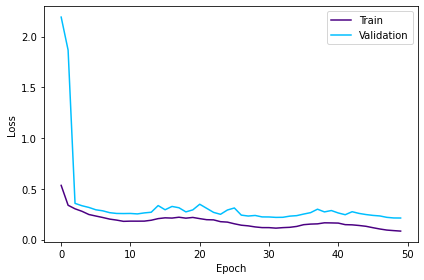

In [4]:
EXPERIMENT_NAME = 'cce_loss__aug'

if not os.path.exists('./saved_models/'+EXPERIMENT_NAME):
    os.makedirs('./saved_models/'+EXPERIMENT_NAME)


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

""" Create the Xception network-based U-Net-like model """
model = unet_xception.get_model(img_size=(224,224), num_classes=2)

""" Create training and validation data generators """
train_gen = PetDataGenerator(data_path='./data/224x224/train', batch_size=8, augmentation=True, shuffle=True)
val_gen = PetDataGenerator(data_path='./data/224x224/val', batch_size=32, augmentation=False, shuffle=False)

""" Optimizer """
opt = keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)

""" Cosine annealing learning rate scheduler """
cos_annealing = CosineAnnealingScheduler(T_max=10, eta_max=1e-3, eta_min=1e-5)

""" Automatically save the best model """
checkpoint = keras.callbacks.ModelCheckpoint('./saved_models/'+EXPERIMENT_NAME+'/{epoch:03d}-{loss:03f}-{val_loss:03f}.h5',
                                             verbose=0, monitor='val_loss',save_best_only=True, mode='auto')

""" Compile model """
model.compile(optimizer=opt, loss="categorical_crossentropy")

""" Train model """
callbacks = [checkpoint, cos_annealing]
history = model.fit(train_gen, validation_data=val_gen, epochs=50, verbose=1, callbacks=callbacks)

""" Save history """
save_history(history, save_path='./logs/'+EXPERIMENT_NAME+'.json')

""" Plot history """  
plot_loss(history, save_path='./plots/'+EXPERIMENT_NAME+'.pdf')

# Experiment 2

### DICE Loss for Semantic Segmentation:

$n$: number of pixels

$c$: classes

$dice\_loss\_square = 1 - \cfrac{1}{c}\sum_{i=0}^{c}\cfrac{\sum_j^n 2y_i^j\hat{y}_i^j + \epsilon}{\sum_j^n y_i^jy_i^j + \sum_j^n\hat{y}_i^j\hat{y}_i^j + \epsilon}$

$\epsilon$ is a very small number to avoid dividing-by-zero problem.

### Experiment 2a
#### w/o Data Augmentation

W0308 15:08:35.183760 16988 deprecation.py:506] From C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:1666: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Epoch 1/50
218/218 [==============================] - 54s 247ms/step - loss: 0.2218 - val_loss: 0.4057 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 55s 254ms/step - loss: 0.1515 - val_loss: 0.4032 - lr: 9.7577e-04
Epoch 3/50
218/218 [==============================] - 52s 239ms/step - loss: 0.1178 - val_loss: 0.1264 - lr: 9.0546e-04
Epoch 4/50
218/218 [==============================] - 52s 240ms/step - loss: 0.1016 - val_loss: 0.1135 - lr: 7.9595e-04
Epoch 5/50
218/218 [==============================] - 55s 254ms/step - loss: 0.0904 - val_loss: 0.1029 - lr: 6.5796e-04
Epoch 6/50
218/218 [==============================] - 54s 247ms/step - loss: 0.0805 - val_loss: 0.0909 - lr: 5.0500e-04
Epoch 7/50
218/218 [==============================] - 54s 246ms/step - loss: 0.0712 - val_loss: 0.1154 - lr: 3.5204e-04
Epoch 8/50
218/218 [==============================] - 55s 250ms/step - loss: 0.0603 - val_loss: 0.0868 - lr: 2.1405e-04
Epoch 9/50
218/218 [========================

C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  if sys.path[0] == '':


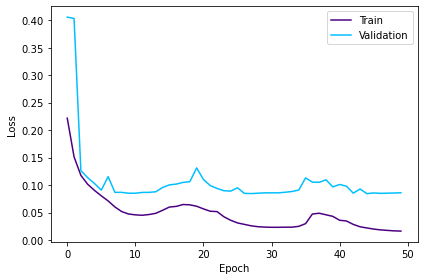

In [3]:
EXPERIMENT_NAME = 'dice_loss__no_aug'

if not os.path.exists('./saved_models/'+EXPERIMENT_NAME):
    os.makedirs('./saved_models/'+EXPERIMENT_NAME)

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

""" Create the Xception network-based U-Net-like model """
model = unet_xception.get_model(img_size=(224,224), num_classes=2)

""" Create training and validation data generators """
train_gen = PetDataGenerator(data_path='./data/224x224/train', batch_size=8, augmentation=False, shuffle=True) # w/o augment
val_gen = PetDataGenerator(data_path='./data/224x224/val', batch_size=32, augmentation=False, shuffle=False)

""" Optimizer """
opt = keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)

""" Cosine annealing learning rate scheduler """
cos_annealing = CosineAnnealingScheduler(T_max=10, eta_max=1e-3, eta_min=1e-5)

""" Automatically save the best model """
checkpoint = keras.callbacks.ModelCheckpoint('./saved_models/'+EXPERIMENT_NAME+'/{epoch:03d}-{loss:03f}-{val_loss:03f}.h5',
                                             verbose=0, monitor='val_loss',save_best_only=True, mode='auto')

""" Compile model """
model.compile(optimizer=opt, loss=loss.dice_loss) # DICE loss

""" Train model """
callbacks = [checkpoint, cos_annealing]
history = model.fit(train_gen, validation_data=val_gen, epochs=50, verbose=1, callbacks=callbacks)

""" Save history """
save_history(history, save_path='./logs/'+EXPERIMENT_NAME+'.json')

""" Plot history """  
plot_loss(history, save_path='./plots/'+EXPERIMENT_NAME+'.pdf')

### Experiment 2b
#### w/ Data Augmentation

Epoch 1/50
218/218 [==============================] - 55s 252ms/step - loss: 0.2943 - val_loss: 0.4062 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 52s 241ms/step - loss: 0.2027 - val_loss: 0.4051 - lr: 9.7577e-04
Epoch 3/50
218/218 [==============================] - 52s 239ms/step - loss: 0.1756 - val_loss: 0.1196 - lr: 9.0546e-04
Epoch 4/50
218/218 [==============================] - 52s 238ms/step - loss: 0.1674 - val_loss: 0.1146 - lr: 7.9595e-04
Epoch 5/50
218/218 [==============================] - 52s 240ms/step - loss: 0.1584 - val_loss: 0.1217 - lr: 6.5796e-04
Epoch 6/50
218/218 [==============================] - 52s 239ms/step - loss: 0.1480 - val_loss: 0.0949 - lr: 5.0500e-04
Epoch 7/50
218/218 [==============================] - 52s 240ms/step - loss: 0.1423 - val_loss: 0.0907 - lr: 3.5204e-04
Epoch 8/50
218/218 [==============================] - 54s 247ms/step - loss: 0.1348 - val_loss: 0.0931 - lr: 2.1405e-04
Epoch 9/50
218/218 [========================

C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  if sys.path[0] == '':


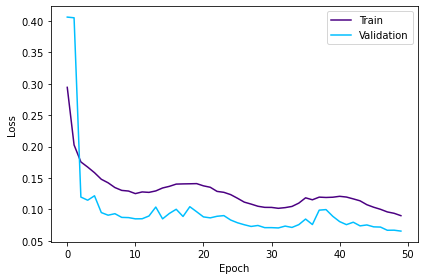

In [11]:
EXPERIMENT_NAME = 'dice_loss__aug'

if not os.path.exists('./saved_models/'+EXPERIMENT_NAME):
    os.makedirs('./saved_models/'+EXPERIMENT_NAME)

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

""" Create the Xception network-based U-Net-like model """
model = unet_xception.get_model(img_size=(224,224), num_classes=2)

""" Create training and validation data generators """
train_gen = PetDataGenerator(data_path='./data/224x224/train', batch_size=8, augmentation=True, shuffle=True) # w/ augment
val_gen = PetDataGenerator(data_path='./data/224x224/val', batch_size=32, augmentation=False, shuffle=False)

""" Optimizer """
opt = keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)

""" Cosine annealing learning rate scheduler """
cos_annealing = CosineAnnealingScheduler(T_max=10, eta_max=1e-3, eta_min=1e-5)

""" Automatically save the best model """
checkpoint = keras.callbacks.ModelCheckpoint('./saved_models/'+EXPERIMENT_NAME+'/{epoch:03d}-{loss:03f}-{val_loss:03f}.h5',
                                             verbose=0, monitor='val_loss',save_best_only=True, mode='auto')

""" Compile model """
model.compile(optimizer=opt, loss=loss.dice_loss) # DICE loss

""" Train model """
callbacks = [checkpoint, cos_annealing]
history = model.fit(train_gen, validation_data=val_gen, epochs=50, verbose=1, callbacks=callbacks)

""" Save history """
save_history(history, save_path='./logs/'+EXPERIMENT_NAME+'.json')

""" Plot history """  
plot_loss(history, save_path='./plots/'+EXPERIMENT_NAME+'.pdf')

In [12]:
gaga = val_gen.__getitem__(0)

idx = 1
img = gaga[0][idx]
mask = gaga[1][idx]

W0308 17:02:55.920765 16988 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


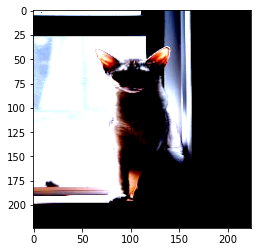

In [13]:
plt.imshow(img)

In [14]:
mask[50]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.

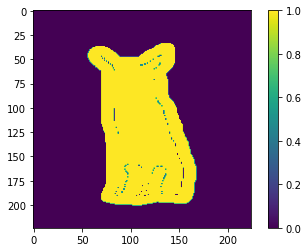

In [15]:
plt.imshow(np.argmax(mask, axis=2))
plt.colorbar()

### Manually Check Model Performance

W0308 17:02:56.927522 16988 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


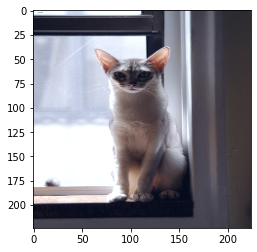

In [16]:
"""
img = cv2.imread('./data/224x224/train/Abyssinian_100.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_ = np.array(img, dtype=np.float32) / 255.

for c in range(3):
    # z-score standardization for each color channel
    img_[:,:,c] = (img_[:,:,c] - pet.mean[c]) / pet.std[c]
"""
 
plt.imshow((img+1.9)/3.8)


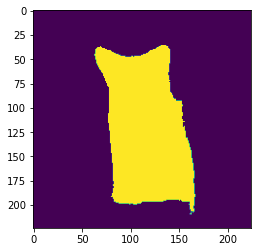

In [17]:
pred = model.predict(np.reshape(img, [-1,224,224,3]))
pred = np.argmax(pred[0], axis=2)
plt.imshow(pred)

W0308 17:03:06.785235 16988 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


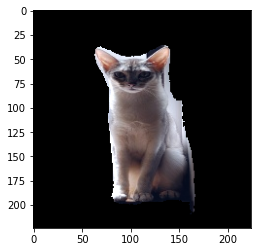

In [18]:
pred = np.reshape(pred, [224,224,1])
plt.imshow(((img+1.9)/3.8) * (np.concatenate([pred, pred, pred], axis=2)))

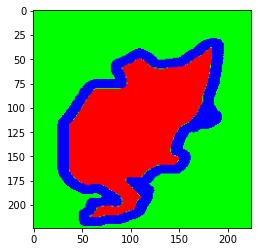

In [28]:
mask = np.load('./data/224x224/train/_Abyssinian_100.npy')

plt.imshow(mask/1.0)

In [6]:
img_, mask_ = pet.data_augmentation(img, mask/1.0, angle_range=(-15,15), scale_range=(0.7,1.3), flip=True)



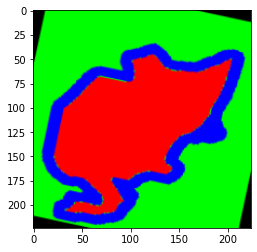

In [7]:
plt.imshow(mask_)

In [32]:
mask[50]


array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

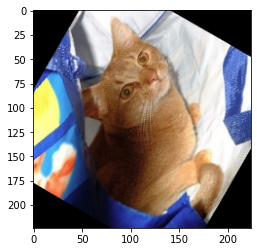

In [8]:
plt.imshow(pet.rotate(image=img, angle=60))

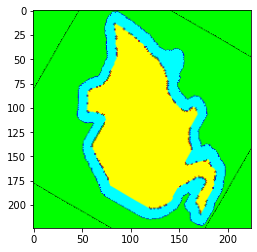

In [14]:
mask_ = pet.rotate(image=mask/1.0, angle=60)
mask_ = np.where(mask_ == [0,0,0], [0,1.0,0] ,mask_)
plt.imshow(mask_)

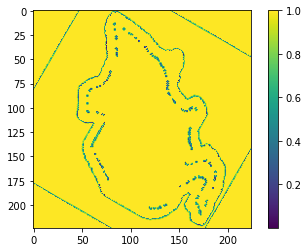

In [22]:
plt.imshow(mask_[:,:,1])
plt.colorbar()

In [12]:
mask/1.0

array([[[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]],

       [[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]],

       [[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]],

       ...,

       [[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]],

       [[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]],

       [[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]]])

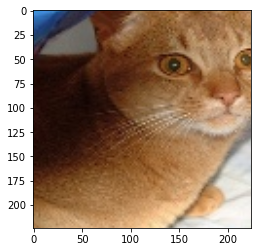

In [9]:
plt.imshow(pet.scale(image=img, scale=2.0))

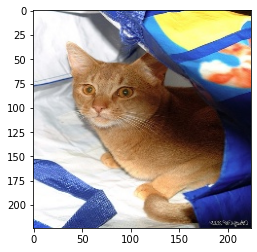

In [10]:
plt.imshow(pet.flip(image=img, vertical=False, horizontal=True))

In [85]:
import random

random.uniform(0, 2.0)

0.9643677775999517